In [1]:
import pandas as pd

import matplotlib.pyplot as plt

---
## Questions
  * Comment compter le nombre de cycles de charges/décharges ?
  * De combien les batteries se sont détériorées ?
---

In [2]:
def read_data(feature_name):
    """Read a specific CSV file given a column name."""
    data = pd.read_csv(f"data_54.38.188.95/{feature_name}.csv")
    # Convert epoch to seconds 
    data["time"] = data["time"] / 10e8
    # Drop wrong column
    data.drop("Battery_status", axis=1, inplace=True)
    return data

In [3]:
charge_now = read_data("charge_now")
charge_now

/home/khazit/Documents/ML/BatteryProbe.ai/.venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,name,time,battery_status,manufacturer,os,uuid,value
0,charge_now,1.601834e+09,NaN,SWD,macos,13370f11455f4f36a0680b9725189375,3289
1,charge_now,1.601834e+09,Full,BYD,linux,5fbc9f85604740eb85dbf9dbd495de67,2760
2,charge_now,1.601834e+09,NaN,SWD,macos,13370f11455f4f36a0680b9725189375,3289
3,charge_now,1.601834e+09,NaN,SWD,macos,13370f11455f4f36a0680b9725189375,3321
4,charge_now,1.601834e+09,NaN,SWD,macos,13370f11455f4f36a0680b9725189375,3321
...,...,...,...,...,...,...,...
175555,charge_now,1.604874e+09,Full,BYD,linux,0a236299cff2433fbd19467990418ba4,2760
175556,charge_now,1.604874e+09,Full,BYD,linux,0a236299cff2433fbd19467990418ba4,2760
175557,charge_now,1.604874e+09,Full,BYD,linux,0a236299cff2433fbd19467990418ba4,2760
175558,charge_now,1.604874e+09,Full,BYD,linux,0a236299cff2433fbd19467990418ba4,2760


In [4]:
charge_now = charge_now.loc[charge_now["battery_status"].isin(["Charging", "Discharging"])]
charge_now = charge_now.sort_values(["time"])

In [5]:
charge_now

,name,time,battery_status,manufacturer,os,uuid,value
1010,charge_now,1.601880e+09,Discharging,BYD,linux,5fbc9f85604740eb85dbf9dbd495de67,2460
1012,charge_now,1.601880e+09,Discharging,BYD,linux,5fbc9f85604740eb85dbf9dbd495de67,2454
1014,charge_now,1.601880e+09,Discharging,BYD,linux,5fbc9f85604740eb85dbf9dbd495de67,2451
1016,charge_now,1.601880e+09,Discharging,BYD,linux,5fbc9f85604740eb85dbf9dbd495de67,2448
1018,charge_now,1.601880e+09,Discharging,BYD,linux,5fbc9f85604740eb85dbf9dbd495de67,2444
...,...,...,...,...,...,...,...
175472,charge_now,1.604873e+09,Charging,BYD,linux,0a236299cff2433fbd19467990418ba4,2732
175473,charge_now,1.604873e+09,Charging,BYD,linux,0a236299cff2433fbd19467990418ba4,2732
175474,charge_now,1.604873e+09,Charging,BYD,linux,0a236299cff2433fbd19467990418ba4,2732
175475,charge_now,1.604873e+09,Charging,BYD,linux,0a236299cff2433fbd19467990418ba4,2732


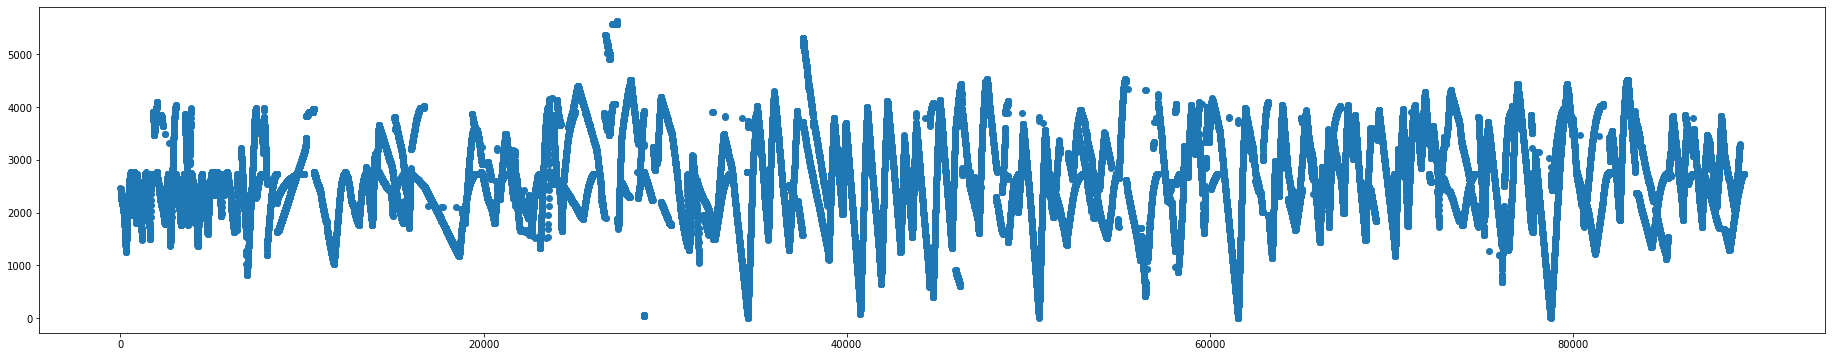

In [6]:
plt.figure(figsize=(32, 6))
plt.scatter([i for i in range(len(charge_now))], charge_now["value"])

In [8]:
MAX_GAP_BETWEEN_SESSIONS = 400  # in seconds
MIN_NUM_POINTS_PER_SESSION = 10
MIN_SESSION_DURATION = 600 # in seconds

In [14]:
def extract_sessions(data):
    """Extract sessions.
    
    Args: 
        data (pd.DataFrame): data from one unique user 
            (uuid should be the same)
            
    Returns: 
        List of sessions (pd.Dataframes)
    """
    sessions = []

    print(f"{uuid} - {len(data)} points")

    while len(data) != 0:
        session = []
        status = data.iloc[0]["battery_status"]
        epoch = data.iloc[0]["time"]
        index = data.iloc[0].name
        session.append(data.iloc[0])

        # A session is ended with a:
        # * battery status change (from discharging to charging for eg)
        # * gap between two consecutive data points is too big
        for index_sess, row_sess in data[~data.index.isin([index])].iterrows():      
            last_index = index_sess
            if row_sess["battery_status"] != status:
                break
            elif row_sess["time"] - epoch > MAX_GAP_BETWEEN_SESSIONS:
                break
            else:
                session.append(row_sess)
            epoch = row_sess["time"]

        # Remove all rows that were processed
        data = data[data.index > last_index]
        if (len(session) > MIN_NUM_POINTS_PER_SESSION) and \
          (session[-1]["time"] - session[0]["time"]) > MIN_SESSION_DURATION:
            sessions.append(session)

    print(f"Extracted {len(sessions)} sessions")
    sessions_df = [pd.DataFrame(session) for session in sessions]
    return sessions_df

In [23]:
n_points = 0
n_sessions = 0
for uuid in charge_now["uuid"].unique():
    subsample = charge_now[charge_now["uuid"] == uuid]    
    n_points += len(subsample)
    sessions_df = extract_sessions(subsample)
    n_sessions += len(sessions_df)
    break # TODO: remove
    
print(f"{n_sessions} sessions from {n_points} points") 

5fbc9f85604740eb85dbf9dbd495de67 - 5649 points
Extracted 38 sessions
38 sessions from 5649 points


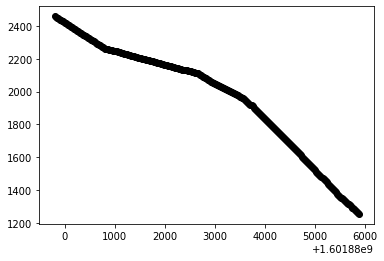

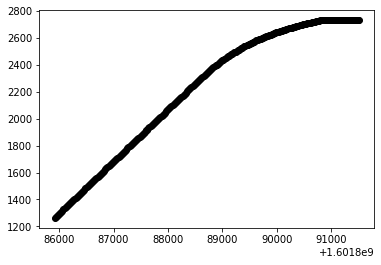

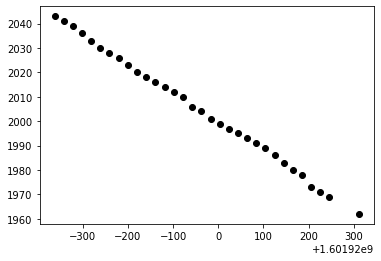

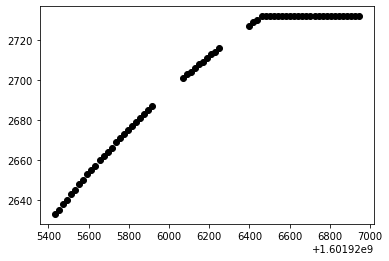

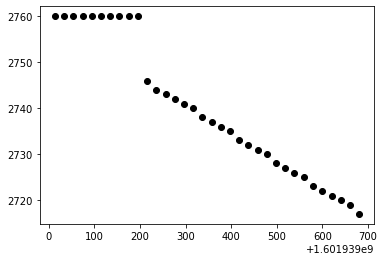

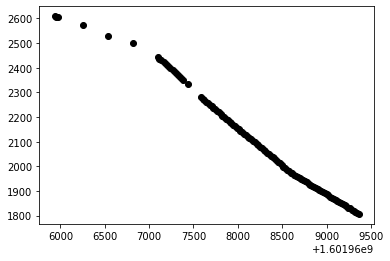

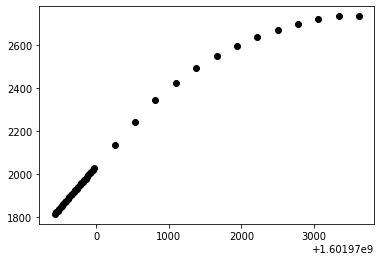

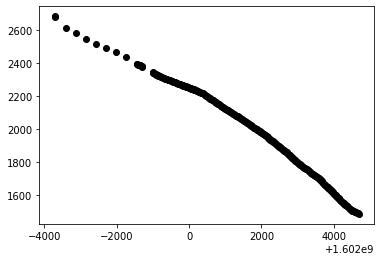

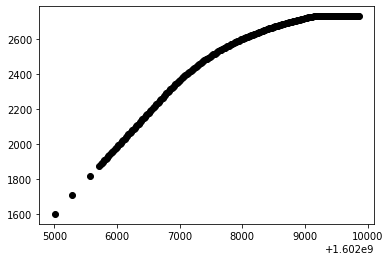

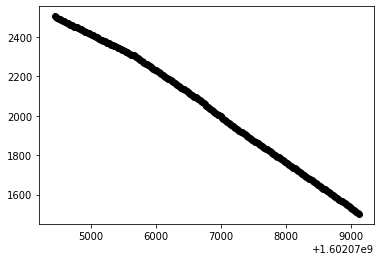

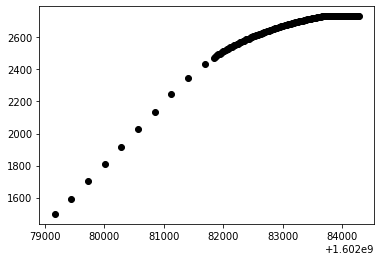

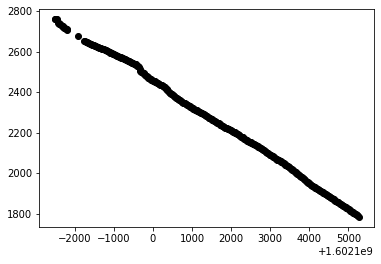

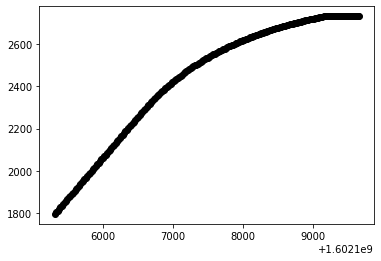

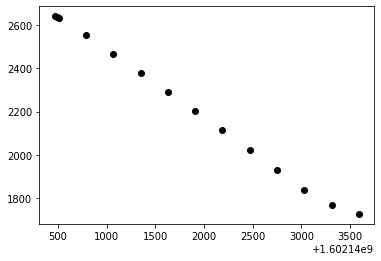

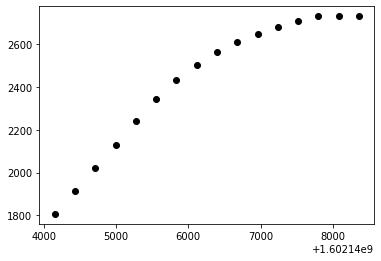

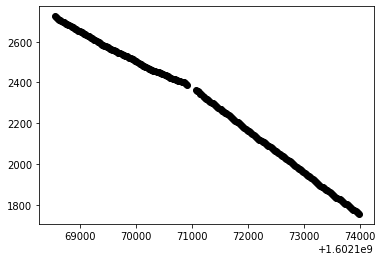

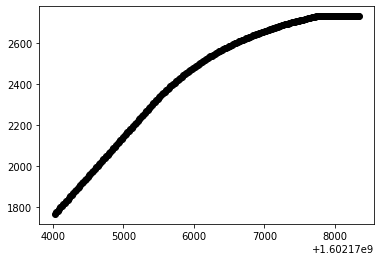

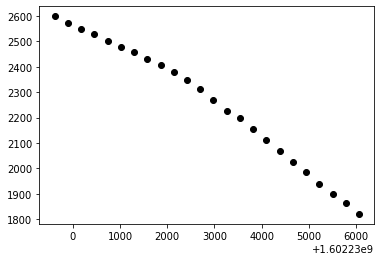

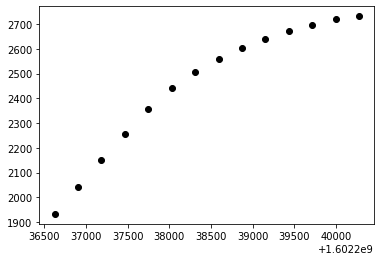

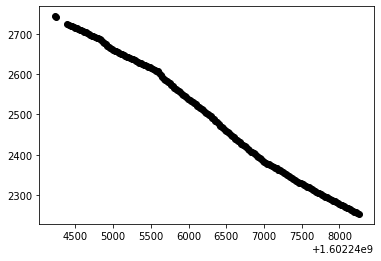

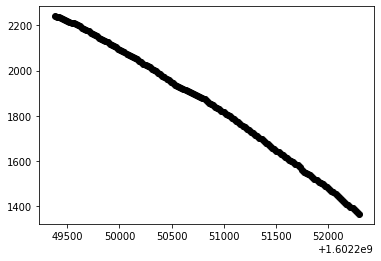

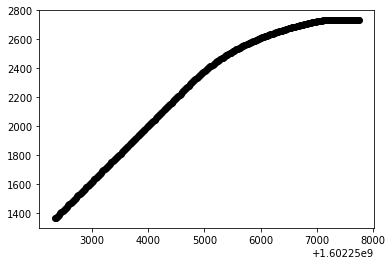

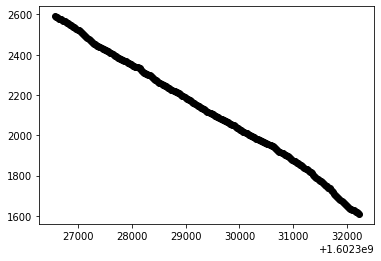

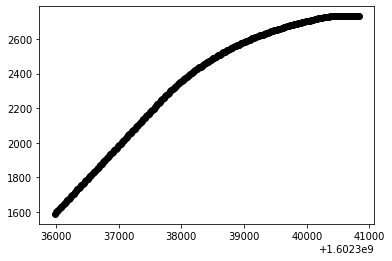

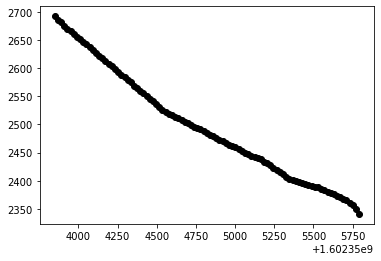

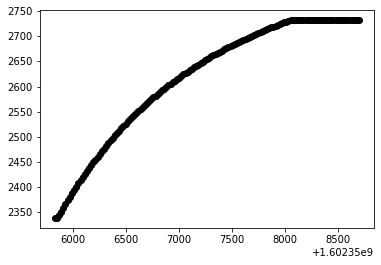

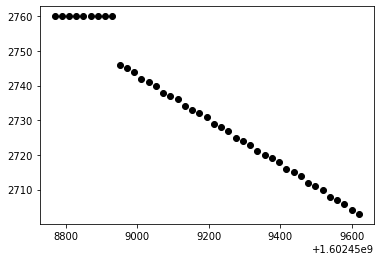

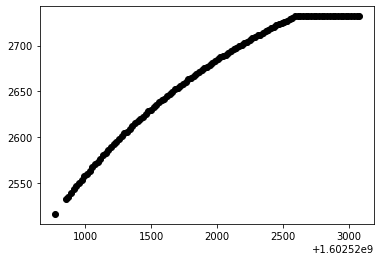

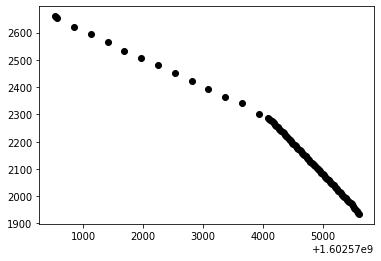

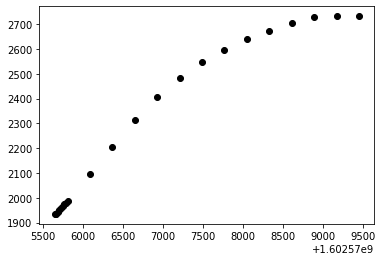

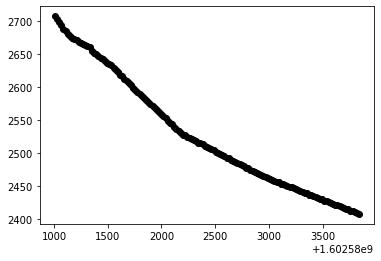

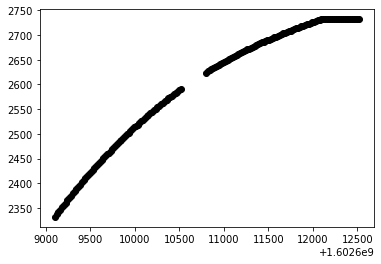

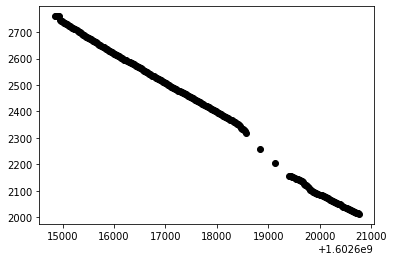

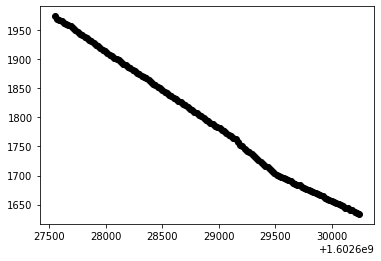

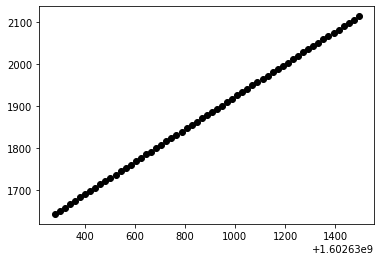

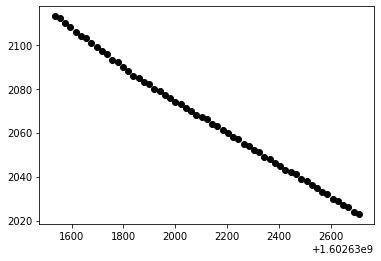

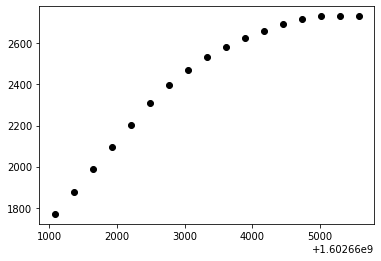

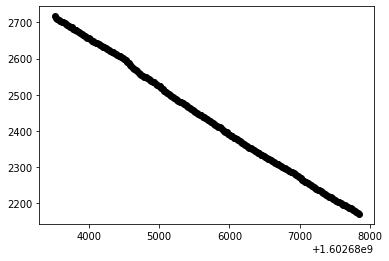

In [28]:
for session_df in sessions_df:
    plt.plot(session_df["time"], session_df["value"], "ko")
    plt.show()